In [1]:
import numpy as np
import scipy as sc
from scipy.special import gammaln
from scipy.special import digamma
%matplotlib inline

from itertools import combinations

import pygraphviz as pgv
from IPython.display import Image
from IPython.display import display

def normalize(A, axis=None):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

def find(cond):
    """
        find indices where the given condition is satisfied
    """
    return list(np.where(cond)[0])

def xtopological_order(adj, pa, ch):
    """
    returns a topological ordering of the nodes given 
    """
    nVertex = adj.shape[0]
    indeg = np.sum(adj, axis = 1)
    zero_in = find(indeg==0)
    topo_order = []
    while zero_in:
        n = zero_in.pop(0)
        topo_order.append(n)
        for j in ch[n]:
            indeg[j] -= 1
            if indeg[j] == 0:
                zero_in.append(j)
                
    if len(topo_order)<nVertex:
        return []
    else:
        return topo_order

def random_DAG(N=26, max_indeg=1, cardinalities=None):
#    if N<27:
#        alphabet = [chr(i+ord('a')) for i in range(N)]
#    else:
    alphabet = [i for i in range(N)]        
    if cardinalities is None:
        cardinalities = [np.random.choice([2,3,4,5]) for a in alphabet]
    indeg = lambda: np.random.choice(range(1,max_indeg))
    parents = {a:[b for b in np.random.choice(alphabet[0:(1 if i==0 else i)], replace=False, size=min(indeg(),i))] for i,a in enumerate(alphabet)}

    states = {a:list(range(cardinalities[i])) for i,a in enumerate(alphabet)}
    
    return alphabet, parents, cardinalities, states
  

In [2]:
  
class DAG_Model:
    def __init__(self, index_names, parents, cardinalities):
        ## Preprocessing the model
        nVertex = len(index_names)
        name2idx = {name: i for i,name in enumerate(index_names)}

        ## Build Graph data structures
        # Adjacency matrix
        adj = np.zeros((nVertex, nVertex), dtype=int)
        for i_name in parents.keys():
            i = name2idx[i_name]
            for m_name in parents[i_name]:
                j = name2idx[m_name]
                adj[i, j] = 1
                
        # Family, Parents and Children
        fa = [[]]*nVertex
        pa = [[]]*nVertex
        ch = [[]]*nVertex
        for n in range(nVertex):
            p = find(adj[n,:])
            pa[n] = p
            fa[n] = [n]+p
            c = find(adj[:,n])
            ch[n] = c
              
        # Sizes
        size = [[]]*nVertex
        for n in range(nVertex):
            size[n] = [1]*nVertex
            for j in fa[n]:
                size[n][j] = cardinalities[j]

        self.nVertex = nVertex
        self.name2idx = name2idx
        self.index_names = index_names
        self.parents = parents
        self.adj = adj
        self.pa = pa
        self.fa = fa
        self.ch = ch

        self.cardinalities = cardinalities
        self.size = size
    def nodename2idx(self, name):
        return self.name2idx[name]
    def nodenames2idx(self, names):
        return [self.name2idx[nm] for nm in names] 
    def nodenames2idxset(self, names):
        return set([self.name2idx[nm] for nm in names])
    def clique_shape(self, idxs):
        '''Returns the shape vector for a clique potential on given indices'''
        shape = [1]*self.nVertex
        for i in idxs:
            shape[i] = cardinalities[i]
        return shape
    def clique_compact_shape(self, idxs):
        '''Returns the shape vector for a clique potential on given indices'''
        shape = [1]*len(idxs)
        for u,i in enumerate(idxs):
            shape[u] = cardinalities[i]
        return shape
    def show_image(self, imstr='file.png'):
        A = pgv.AGraph(directed=True)

        for i_n in self.index_names:
            A.add_node(self.nodename2idx(i_n), label=i_n)
            for j_n in self.parents[i_n]:
                A.add_edge(self.nodename2idx(j_n), self.nodename2idx(i_n))

        A.layout(prog='dot')
        A.draw(imstr)
        return imstr
    def show_ug_image(self, UG, imstr='file.png'):
        A = pgv.AGraph(directed=False)

        for i_n in range(UG.shape[0]):
            A.add_node(i_n, label=i_n)
            for j_n in find(UG[i_n,:]):
                if j_n>i_n:
                    A.add_edge(j_n, i_n)

        A.layout(prog='dot')
        A.draw(imstr)
        return imstr
    def make_cliques(self, visibles=None, show_graph=False):
        if visibles is None:
            C = G.fa
        else:
            C = G.fa+[visibles]
           
        # Moral Graph
        MG = np.zeros((G.nVertex, G.nVertex)) 

        for F in C:
            for edge in combinations(F,2):
                MG[edge[0], edge[1]] = 1  
                MG[edge[1], edge[0]] = 1  

        if show_graph:
            imf = self.show_ug_image(MG,imstr='MG.png')
            display(Image(imf))

                
        elim = []
        Clique = []
        N = self.nVertex
        visited = [False]*N

        # Find an elimination sequence
        # Based on greedy search 
        # Criteria, select the minimum induced clique size
        for j in range(N):

            min_clique_size = np.inf
            min_idx = -1
            for i in range(N):
                if not visited[i]:
                    neigh = find(MG[i,:])
                    nm = np.prod(self.clique_shape(neigh+[i]))

                    if min_clique_size > nm:
                        min_idx = i
                        min_clique_size = nm

            neigh = find(MG[min_idx,:])
            temp = set(neigh+[min_idx])

            is_subset = False
            for CC in Clique:
                if temp.issubset(CC):
                    is_subset=True
            if not is_subset:
                Clique.append(temp)

            # Remove the node from the moral graph
            for edge in combinations(neigh,2):
                MG[edge[0], edge[1]] = 1
                MG[edge[1], edge[0]] = 1

            MG[min_idx,:] = 0
            MG[:, min_idx] = 0
            elim.append(min_idx)
            visited[min_idx] = True
            if show_graph:
                imf = self.show_ug_image(MG,imstr='MG'+str(j)+'.png')
                display(Image(imf))
            
        return elim, Clique    
    
   

## Example 1: A Simple chain

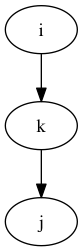

In [17]:
## Define the model
index_names = ['i', 'j', 'k']
cardinalities = [10, 20, 3]
parents = {'i': [], 'j': ['k'], 'k': ['i']}
#parents = {'k': [], 'i': ['k'], 'j': ['k']}
gamma = 0.1
visibles = ['i','j']

G = DAG_Model(index_names, parents, cardinalities=cardinalities)
imstr = G.show_image()
display(Image(imstr))

## Example 2: Chest Clinic

This is a classical toy medical expert system example from the classical 1988 paper of
Lauritzen and Spiegelhalter.
https://www.jstor.org/stable/pdf/2345762.pdf

 Shortness-of-breath (dyspnoea) may be due to tuberculosis, lung cancer or
 bronchitis, or none of them, or more than one of them. A recent visit to Asia
 increases the chances of tuberculosis, while smoking is known to be a risk factor
 for both lung cancer and bronchitis. The results of a single chest X-ray do not
 discriminate between lung cancer and tuberculosis, as neither does the presence
 or absence of dyspnoea.


Also see: http://www.bnlearn.com/documentation/man/asia.html


In this toy domain, a patient can have three diseases:

* T: Tuberculosis
* L: Lung Cancer
* B: Bronchitis 

We also have the following possible a-priori effects on contracting a disease:

* A: There is a Tuberculosis epidemic in Asia, so a visit may have an effect on Tuberculosis
* S: Smoking history is known to have an effect both on Lung cancer and Bronchitis

Logical variables may be present, for example 
* E: Either T or L or both

Symptoms or medical test results

* D: The patient can show Dyspnea: Difficult breathing; shortness of breath, depending on T,L or B 
* X: X Ray gives a positive response if either Lung Cancer or Tuberclosis, or both. B does not have a direct efect on the outcome of the X-Ray


In [12]:
# [A][S][T|A][L|S][B|S][E|T:L][X|E][D|B:E]

index_names = ['A', 'S', 'T', 'L', 'B', 'E', 'X', 'D']
parents = {'A':[], 'S':[], 'T':['A'], 'L':['S'], 'B':['S'], 'E':['T','L'], 'X':['E'], 'D':['B','E']}

## A Method for systematically entering the conditional probability tables

# P(A = Yes) = 0.01
# P(S = Yes) = 0.5
# P(T=Positive | A=Yes) = 0.05
# P(T=Positive | A=No) = 0.01
# P(L=Positive | S=Yes) = 0.1
# P(L=Positive | S=No) = 0.01
# P(B=Positive | S=Yes) = 0.6
# P(B=Positive | S=No) = 0.3
# P(E=True | L=Positive, T=Positive) = 1
# P(E=True | L=Positive, T=Negative) = 1
# P(E=True | L=Negative, T=Positive) = 1
# P(E=True | L=Negative, T=Negative) = 0
# P(X=Positive | E=True) = 0.98
# P(X=Positive | E=False) = 0.05
# P(D=Positive | E=True, B=Positive) = 0.9
# P(D=Positive | E=True, B=Negative) = 0.7
# P(D=Positive | E=False, B=Positive) = 0.8
# P(D=Positive | E=False, B=Negative) = 0.1

states = {'A':['No', 'Yes'], 
          'S':['No', 'Yes'], 
          'T':['Negative','Positive'], 
          'L':['Negative','Positive'], 
          'B':['Negative','Positive'], 
          'E':['False', 'True'], 
          'X':['Negative','Positive'],
          'D':['Negative','Positive']}

# Conditional Probability Tables
cp_tables = {('A'): [0.99, 0.01],
             ('S'): [0.5, 0.5],
             ('T','A'): [[0.99, 0.01],[0.95,0.05]],
             ('L','S'): [[0.99, 0.01],[0.9,0.1]],
             ('B','S'): [[0.7,0.3],[0.4, 0.6]],
             ('E','T','L'): [[[1.,0.],[0.,1.]] , [[0.,1.],[0.,1.]]],
             ('X','E'): [[0.95, 0.05], [0.02, 0.98]],
             ('D','B','E'):[[[0.9,0.1],[0.2,0.8]],[[0.3,0.7],[0.1,0.9]]]
            }

cardinalities = [len(states[a]) for a in index_names]
theta = make_cp_tables(index_names, cardinalities, cp_tables)


G = DAG_Model(index_names=index_names, parents=parents, cardinalities=cardinalities)

imstr = G.show_image()
Image(imstr)

visibles = ['A', 'X', 'D']
#visibles = []

In [16]:
theta[2].shape

(2, 1, 2, 1, 1, 1, 1, 1)

In [11]:
def random_parents(alphabet, max_indeg=3):
    N = len(alphabet)
    print(alphabet)
    indeg = lambda: np.random.choice(range(0,max_indeg+1))
    parents = {a:[b for b in np.random.choice(alphabet[0:(1 if i==0 else i)], replace=False, size=min(indeg(),i))] for i,a in enumerate(alphabet)}
    return parents

def random_cardinalities(alphabet, cardinality_choices=[2,3,4,5]):
       return [np.random.choice(cardinality_choices) for a in alphabet]
    
def random_states(alphabet, cardinalities):
        return {a:[a+"_state_"+str(u) for u in range(cardinalities[i])] for i,a in enumerate(alphabet)}
    

def clique_shape(cardinalities, family):
    N = len(cardinalities)
    size = [1]*N
    for i in family:
        size[i] = cardinalities[i] 
    return size

def clique_prior_marginal(cardinalities, shape):
    U = 1
    for a1,a2 in zip(shape, cardinalities):
        U = U*a2/a1
    return U
    
def random_dirichlet_cp_table(gamma, cardinalities, n, pa_n):
    '''
        gamma : Dirichlet shape parameter
        cardinalities : List of number of states of each variable
        n, pa_n : Output a table of form p(n | pa_n ), n is an index, pa_n is the list of parents of n 
    '''
    N = len(cardinalities)
    cl_shape = clique_shape(cardinalities, [n]+pa_n)
    U = clique_prior_marginal(cardinalities, cl_shape)
    return normalize(np.random.gamma(shape=gamma*U, size=cl_shape), axis=n)

def index_names_to_num(index_names, names):
    name2idx = {name: i for i,name in enumerate(index_names)}
    return [name2idx[nm] for nm in names] 

def make_cp_tables(index_names, cardinalities, cp_tables):
    N = len(index_names)
    theta = [[]]*N

    for c in cp_tables:
        nums = index_names_to_num(index_names, c)
        n = nums[0]
        idx = list(reversed(nums))
        theta[n] = np.einsum(np.array(cp_tables[c]), idx, sorted(idx)).reshape(clique_shape(cardinalities,idx))
    
    return theta

def make_random_cp_tables(index_names, cardinalities, parents, gamma):
    N = len(index_names)
    theta = [[]]*N
    for n,a in enumerate(index_names):
        theta[n] = random_dirichlet_cp_table(gamma, cardinalities, n, index_names_to_num(index_names, parents[a]))
        #print(a, parents[a])
        #print(theta[n].shape)
        #print('--')
    return theta


def make_adjacency_matrix(index_names, parents):
        nVertex = len(index_names)
        name2idx = {name: i for i,name in enumerate(index_names)}

        ## Build Graph data structures
        # Adjacency matrix
        adj = np.zeros((nVertex, nVertex), dtype=int)
        for i_name in parents.keys():
            i = name2idx[i_name]
            for m_name in parents[i_name]:
                j = name2idx[m_name]
                adj[i, j] = 1

        return adj

def make_families(index_names, parents):
    
    adj = make_adjacency_matrix(index_names, parents)
    # Possibly check topological ordering
    # toposort(adj)
    
    # Family, Parents and Children
    fa = [[]]*nVertex
    #pa = [[]]*nVertex
    #ch = [[]]*nVertex
    for n in range(nVertex):
        p = find(adj[n,:])
        #pa[n] = p
        fa[n] = [n]+p
        #c = find(adj[:,n])
        #ch[n] = c
    
    return fa


def make_cliques(families, cardinalities, visibles=None):
    
    N = len(families)
    show_graph=False
    
    if visibles:
        C = families+[visibles]
    else:
        C = families

    # Moral Graph
    MG = np.zeros((N, N)) 

    for F in C:
        for edge in combinations(F,2):
            MG[edge[0], edge[1]] = 1  
            MG[edge[1], edge[0]] = 1  

    if show_graph:
        imf = show_ug_image(MG,imstr='MG.png')
        display(Image(imf))


    elim = []
    Clique = []
    visited = [False]*N

    # Find an elimination sequence
    # Based on greedy search 
    # Criteria, select the minimum induced clique size
    for j in range(N):

        min_clique_size = np.inf
        min_idx = -1
        for i in range(N):
            if not visited[i]:
                neigh = find(MG[i,:])
                nm = np.prod(clique_shape(cardinalities, neigh+[i]))

                if min_clique_size > nm:
                    min_idx = i
                    min_clique_size = nm

        neigh = find(MG[min_idx,:])
        temp = set(neigh+[min_idx])

        is_subset = False
        for CC in Clique:
            if temp.issubset(CC):
                is_subset=True
        if not is_subset:
            Clique.append(temp)

        # Remove the node from the moral graph
        for edge in combinations(neigh,2):
            MG[edge[0], edge[1]] = 1
            MG[edge[1], edge[0]] = 1

        MG[min_idx,:] = 0
        MG[:, min_idx] = 0
        elim.append(min_idx)
        visited[min_idx] = True
        if show_graph:
            imf = self.show_ug_image(MG,imstr='MG'+str(j)+'.png')
            display(Image(imf))

    return Clique, elim   


index_names = ['A', 'S', 'T', 'L', 'B', 'E', 'X', 'D']
parents = random_parents(index_names)
families = make_families(index_names, parents)
cardinalities = random_cardinalities(index_names)
states = random_states(index_names, cardinalities)
Clique, elim_seq = make_cliques(families, cardinalities, visibles=None)

gamma = 0.01
theta = make_random_cp_tables(index_names, cardinalities, parents, gamma)

print(parents)
print(cardinalities)
print(states)
theta[0].shape

['A', 'S', 'T', 'L', 'B', 'E', 'X', 'D']
{'T': ['S', 'A'], 'X': ['B'], 'E': ['A'], 'B': ['S', 'L', 'T'], 'L': [], 'S': ['A'], 'D': ['X', 'S'], 'A': []}
[3, 5, 4, 5, 5, 4, 2, 2]
{'T': ['T_state_0', 'T_state_1', 'T_state_2', 'T_state_3'], 'X': ['X_state_0', 'X_state_1'], 'E': ['E_state_0', 'E_state_1', 'E_state_2', 'E_state_3'], 'B': ['B_state_0', 'B_state_1', 'B_state_2', 'B_state_3', 'B_state_4'], 'L': ['L_state_0', 'L_state_1', 'L_state_2', 'L_state_3', 'L_state_4'], 'S': ['S_state_0', 'S_state_1', 'S_state_2', 'S_state_3', 'S_state_4'], 'D': ['D_state_0', 'D_state_1'], 'A': ['A_state_0', 'A_state_1', 'A_state_2']}


(3, 1, 1, 1, 1, 1, 1, 1)

In [19]:
vis = None

if vis:
    print('True')
else:
    print('False')

False


In [9]:
theta[5].shape

(1, 1, 1, 1, 4, 3, 1, 1)

In [157]:
clique_shape(cardinalities, [1,0,7])

[4, 5, 1, 1, 1, 1, 1, 4]

In [154]:
print(index_names)
index_names_to_num(index_names, ['A','D','S','X'])

['A', 'S', 'T', 'L', 'B', 'E', 'X', 'D']


[0, 7, 1, 6]

In [135]:
n = 3
pa = [0,2,5]
[n]+pa

[3, 0, 2, 5]

In [131]:
random_dirichlet_cp_table(0.01, cardinalities, 7, [0,1,2,4]).shape

(3, 5, 3, 1, 4, 1, 1, 5)

In [134]:
shape = clique_shape(cardinalities, [7, 0,1,2,4])
clique_prior_marginal(cardinalities, shape)

75.0

In [116]:
G.size

[[2, 1, 1, 1, 1, 1, 1, 1],
 [1, 2, 1, 1, 1, 1, 1, 1],
 [2, 1, 2, 1, 1, 1, 1, 1],
 [1, 2, 1, 2, 1, 1, 1, 1],
 [1, 2, 1, 1, 2, 1, 1, 1],
 [1, 1, 2, 2, 1, 2, 1, 1],
 [1, 1, 1, 1, 1, 2, 2, 1],
 [1, 1, 1, 1, 2, 2, 1, 2]]

The correct initialization of probability tables is important but can be tricky.

We define three catalogs:

parents: Keys are node names, the values are lists of parents. When a node does not have any parent, the corresponding list is empty.

states: Keys are node names, values are the labels of each state of a random variable.

cp_tables: Keys are tuples of form (n,parents[n]), Values are probability values. The order of the
variables defining a key is important in matching the correct probabilities to state combinations.

See the conditional probability definition for p(D|B, E). The key is (D,B,E), the probabilities are defined on a tree
in the reverse order, i.e starting from E, then B, then D.

Reshape the tables

In [5]:
theta = [[]]*G.nVertex

for c in cp_tables:
    n = G.name2idx[c[0]]
    idx = list(reversed(G.nodenames2idx(c)))
    theta[n] = np.einsum(np.array(cp_tables[c]), idx, sorted(idx)).reshape(G.clique_shape(idx))

In [86]:
P = multiply(theta,range(G.nVertex))

In [95]:
marginalize(P, [7], G)

array([[[[[[[[ 0.5640294,  0.4359706]]]]]]]])

## Example 4: A random Model

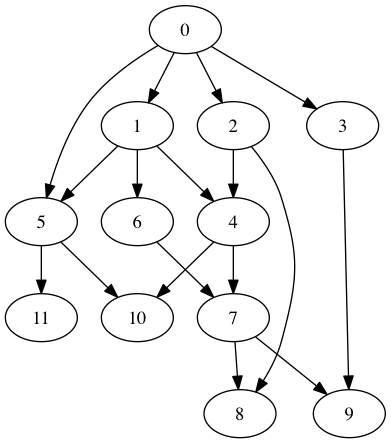

In [3]:
alphabet, parents,  cardinalities = random_DAG(12, max_indeg=3)
G = DAG_Model(index_names=alphabet, parents=parents,  cardinalities=cardinalities)

imstr = G.show_image()
display(Image(imstr))

visibles = alphabet[-4:]

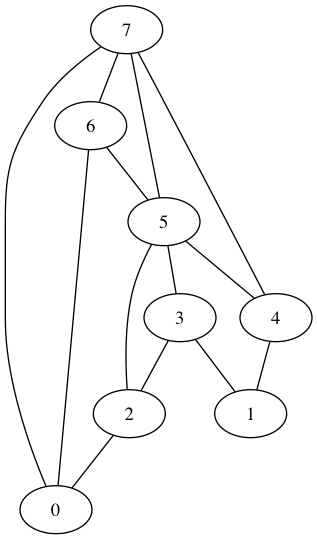

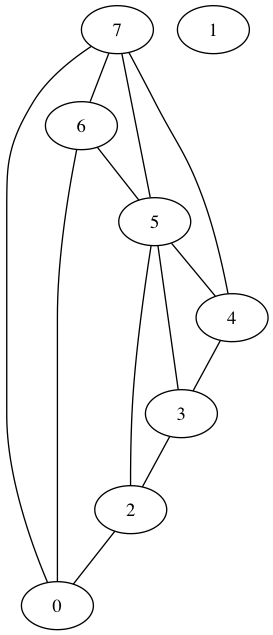

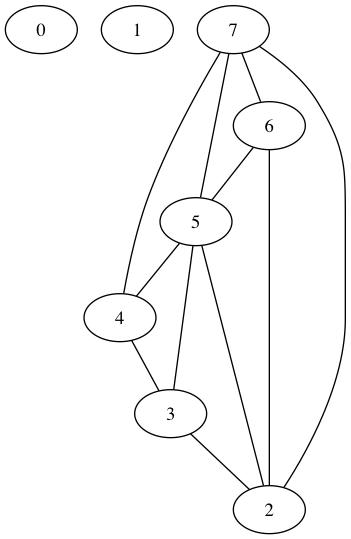

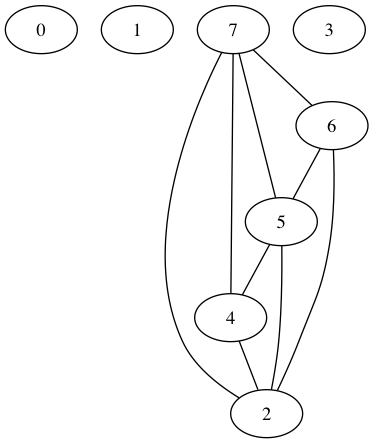

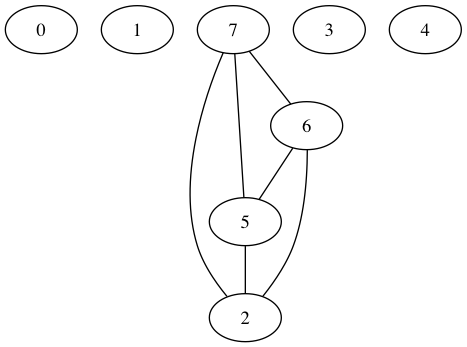

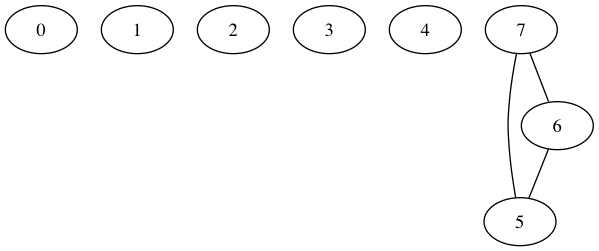

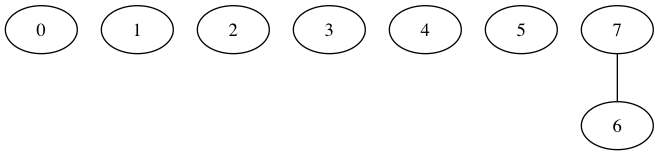

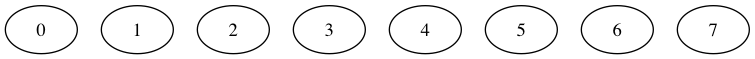

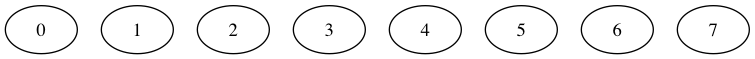

[1, 0, 3, 4, 2, 5, 6, 7]
[{1, 3, 4}, {0, 2, 6, 7}, {2, 3, 4, 5}, {2, 4, 5, 7}, {2, 5, 6, 7}]


In [10]:
elim, Clique = G.make_cliques(visibles, show_graph=True)

print(elim)
print(Clique)

## Example 5: A Hidden Markov Model

In [ ]:
index_names = ['X1', 'X2', 'X3', 'X4', 'Y1', 'Y2', 'Y3', 'Y4']
visibles = []
parents = {'X1':[], 'Y1':['X1'], 'X2':['X1'], 'Y2':['X2'], 'X3':['X2'], 'Y3':['X3'], 'X4':['X3'], 'Y4':['X4'] }
cardinalities = [2]*8

G = DAG_Model(index_names=index_names, parents=parents, visible_names=visibles, cardinalities=cardinalities)

imstr = G.show_image()
Image(imstr)

# Building an inference engine

In [4]:
def mst(E, N):
    """
    Generate a Spanning Tree of a graph with N nodes by Kruskal's algorithm, 
    given preordered edge set E with each edge as (weight, v1, v2)
    
    For a minimum spanning tree, use
    E.sort()
    mst(E, N)
    
    For a maximum spanning tree, use
    E.sort(reverse=True)
    mst(E, N)
    """
    
    parent = list(range(N))
    spanning_tree = {i:[] for i in range(N)}

    def find_v(vertex):
        v = vertex
        while parent[v] != v:
            v = parent[v]
        return v

    def union(v1, v2):
        root1 = find_v(v1)
        root2 = find_v(v2)
        if root1 != root2:
            parent[root2] = root1
    
    for edge in E:
        weight, v1, v2 = edge
        p1, p2 = find_v(v1), find_v(v2)
        if p1 != p2:
            union(p1, p2)
            spanning_tree[v1].append(v2)
            spanning_tree[v2].append(v1)
            
    return spanning_tree

def bfs(adj_list, root):
    """
        Breadth-first search starting from the root
        
        Returns a BFS order, and a BFS tree as an array parent[i] 
        The root node has parent[rootnode] = -1
    """
    N = len(adj_list)
    visited = [False]*N
    parent = [-1]*N
    
    queue = [root]
    order = []
    while queue:
        v = queue.pop(0)
        if not visited[v]:
            visited[v] = True
            for w in adj_list[v]:
                if not visited[w]:
                    parent[w] = v
                    queue.append(w) 
            order.append(v)
            

    return order, parent

In [5]:
def is_leaf(i, parent):
    return  not (i in parent)

def is_root(i, parent):
    return parent[i] == -1

def make_list_receive_from(parent):
    lst = [[] for i in range(len(parent)) ]
    for i,p in enumerate(parent):
        if p!= -1:
            lst[p].append(i)
    
    return lst

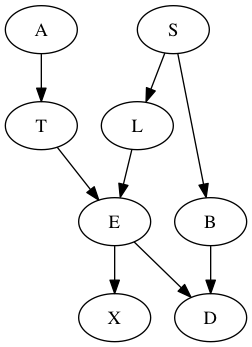

In [6]:

def multiply(theta, idx): 
    ## Multiply a subset of a given list of potentials
    par = [f(n) for n in idx for f in (lambda n: theta[n], lambda n: range(len(theta)))]+[range(len(theta))]    
    return np.einsum(*par)

def marginalize(Cp, idx, G):
    return np.einsum(Cp, range(G.nVertex), [int(s) for s in sorted(idx)]).reshape(G.clique_shape(idx))


class Engine():
    def __init__(self, G, visibles, alpha=None, theta=None, gamma=0.01):
        
        self.elim, self.Clique = G.make_cliques(visibles)

        # Assign each conditional Probability table to one of the Clique potentials
        self.Pot = G.fa
        self.Clique2Pot = np.zeros((len(self.Clique), len(self.Pot)))
        selected = [False]*len(self.Pot)
        for i,c in enumerate(self.Clique):
            for j,p in enumerate(self.Pot):
                if not selected[j]:
                    self.Clique2Pot[i,j] = set(p).issubset(c)
                    if self.Clique2Pot[i,j]: 
                        selected[j] = True

        # Find the root clique
        # In our case it will be the one where all the visibles are a subset of
        self.RootClique = -1
        for i,c in enumerate(self.Clique):
            if set(visibles).issubset(c):
                self.RootClique = i
                break


        self.junction_graph_edges = []
        for i,p in enumerate(self.Clique):
            for j,q in enumerate(self.Clique):
                ln = len(p.intersection(q))
                if i<j and ln>0:
                    self.junction_graph_edges.append((ln,i,j)) 
        self.junction_graph_edges.sort(reverse=True)
        self.mst = mst(self.junction_graph_edges, len(self.Clique))
        self.order, self.parent = bfs(self.mst, self.RootClique)
        self.receive_from = make_list_receive_from(self.parent)

        # Setup the data structures for the Junction tree algorithm
        self.SeparatorPot = dict()
        self.CliquePot = dict()

        self.G = G
        
        if alpha is None and theta is None:
            self.random_init(gamma)
        else:
            self.theta = theta
            self.alpha = alpha
        
    def random_init(self, gamma):
        self.theta = dict()
        self.alpha = dict()
        for n in range(self.G.nVertex):
            U = 1
            for a1,a2 in zip(self.G.size[n], self.G.cardinalities):
                U = U*a2/a1

            self.alpha[n] = gamma*U*np.ones(self.G.size[n])
            self.theta[n] = normalize(np.random.gamma(shape=gamma*U, size=self.G.size[n]), axis=n)

    
    def propagate(self, X):
        #print('Collection Stage')

        E_S = dict()
            
        for c in reversed(self.order):
            #print('Processing Clique', c, Clique[c])   
            self.CliquePot[c] = np.ones(self.G.clique_shape(self.Clique[c]))
            for p in self.receive_from[c]:
                self.CliquePot[c] *= self.SeparatorPot[(p,c)]

            #for th in find(Clique2Pot[c, :]):
            #    print('Multiply ', Pot[th])

            idx = find(self.Clique2Pot[c, :])
            if idx:
                self.CliquePot[c] *= multiply(self.theta, idx) 
                #print(CliquePot[c].shape)

            if not is_root(c, self.parent):
                idx = self.Clique[self.parent[c]].intersection(self.Clique[c])
                self.SeparatorPot[(c,self.parent[c])] = marginalize(self.CliquePot[c], idx, self.G)
                #print('Compute Separator potential of', c, 'with', parent[c],'on', Clique[parent[c]].intersection(Clique[c]))

        SepX = marginalize(self.CliquePot[self.RootClique], visibles, self.G)
        self.CliquePot[self.RootClique] *= X/SepX
        #print('*Compute Separator potential with observations', visibles)
        #print('*Multiply Observations', visibles)
        #print('*Divide Separator by separator potentials', visibles)

        for n in find(self.Clique2Pot[self.RootClique, :]):
            #print(n)
            #print('Compute Marginal ', Pot[n])
            E_S[n] = marginalize(self.CliquePot[self.RootClique], self.Pot[n], self.G)

        #print('Distribution Stage')
        for c in self.order[1:]:
            #print('Processing Clique', c, Clique[c])
            idx = self.Clique[self.parent[c]].intersection(self.Clique[c])
            self.CliquePot[c] *= marginalize(self.CliquePot[self.parent[c]], idx, self.G)/self.SeparatorPot[(c,self.parent[c])]
            #print('Compute Separator potential of', parent[c], 'with', c, 'on', Clique[parent[c]].intersection(Clique[c]))
            #print('Divide by the old separator potential and multiply with the clique potential')

            for n in find(self.Clique2Pot[c, :]):
                #print(n)
                #print('Compute Marginal ', Pot[n])
                #E_S[n] = normalize(marginalize(self.CliquePot[c], self.Pot[n], self.G), axis=n)
                E_S[n] = marginalize(self.CliquePot[c], self.Pot[n], self.G)
                
        return E_S

index_names = ['A', 'S', 'T', 'L', 'B', 'E', 'X', 'D']
parents = {'A':[], 'S':[], 'T':['A'], 'L':['S'], 'B':['S'], 'E':['T','L'], 'X':['E'], 'D':['B','E']}
cardinalities = [3,2,3,4,2,3,2,4]

G = DAG_Model(index_names=index_names, parents=parents, cardinalities=cardinalities)

imstr = G.show_image()
display(Image(imstr))

visibles = G.nodenames2idxset(['A', 'X', 'D'])
X = np.random.choice(range(10), size=G.clique_shape(visibles))

## Generate random potentials
gamma = 0.01

eng = Engine(G, visibles=visibles, gamma=gamma)




In [7]:
E_S_new = eng.propagate(X)


In [8]:
P = multiply(eng.theta, range(G.nVertex))
P /= marginalize(P, visibles, G)
E_S = X*P

In [9]:
n = 5
print(marginalize(E_S, G.fa[n], G).flatten())
print(E_S_new[n].flatten())

[  1.35603355e-01   7.78919890e-01   9.30222047e+00   8.52044905e-01
   1.50816588e+00   7.47754493e+00   1.60681253e+01   4.00318154e+00
   1.27066394e+00   3.07265969e+00   4.92704800e+00   3.33596851e+00
   1.36229199e-01   7.48599474e-01   4.30528411e+00   2.79380952e+00
   1.30589541e-01   2.69966817e+00   4.56720562e+00   5.56991326e-01
   3.46008867e+00   5.30931331e+00   2.36723214e-01   8.37242259e-01
   4.13077941e+00   1.13671902e+00   2.28286141e+00   3.27088246e-03
   6.64542353e+00   7.80441629e-01   5.20193573e+00   1.12964247e+00
   3.41431614e+00   6.15371520e-01   5.27941545e+00   8.65931973e-01]
[  1.35603355e-01   7.78919890e-01   9.30222047e+00   8.52044905e-01
   1.50816588e+00   7.47754493e+00   1.60681253e+01   4.00318154e+00
   1.27066394e+00   3.07265969e+00   4.92704800e+00   3.33596851e+00
   1.36229199e-01   7.48599474e-01   4.30528411e+00   2.79380952e+00
   1.30589541e-01   2.69966817e+00   4.56720562e+00   5.56991326e-01
   3.46008867e+00   5.30931331e+0